<div style="text-align: right">INFO 6105 Data Sci Engineering Methods and Tools, Week 6 Lecture 2</div>
<div style="text-align: right">Dino Konstantopoulos, 10 October 2019, reproduction of a notebook by Ricky Kim, heavily modified</div>

# Red Sox

I wanted to give you another sport to look into, other than **basketball**, which I know is popular in **China**. I wanted to try **Cricket**, which is popular in **India**, but I'm afraid I don't know much about Cricket. However, **baseball** is a close cousin to Cricket, and one of the most data-analyzed sports in history. As a successful data-analyst for the Red Sox, you can make million dollar salaries!

I googled for interesting bayesian analyses on baseball and stumbled upon [this one](https://towardsdatascience.com/bayesball-bayesian-analysis-of-batting-average-102e0390c0e4). As usual, it has a lot of bugs, so I fixed them for you.

We are also next to the home of the storied **Boston Red Sox**, and you need to go at least one home game while you;re at Northeastern!

<br />
<center>
    <img src="images/redsox.jpg" width=200 />
</center>

- "*I don't know whether you know it, but baseball's appeal is decimal points. No other sport relies as totally on continuity, statistics, orderliness of these. Baseball fans pay more attention to numbers than CPAs.*" - Sportswriter Jim Murray

Maybe the more important aspect of this game is the individual nature of it. During an **at-bat**, who is playing in the outfield has very little effect on whether or not the batter can hit a home run. In other sports like football and basketball, that is not the case. This is what makes baseball stats useful for player comparison.

Baseball stats consist of numerous metrics, some of them straightforward, some of them more advanced. [Batting average]( http://m.mlb.com/glossary/standard-stats/batting-average) is an example of a straightforward metric. In baseball, the [batting average](https://en.wikipedia.org/wiki/List_of_Major_League_Baseball_career_batting_average_leaders) (BA) is defined by the number of hits divided by at bats. It is usually reported to three decimal places.

- "*Still, what [batting average](https://www.cbssports.com/mlb/news/what-is-the-best-offensive-stat/) does have over all the other statistics is history and context. We all know what a .300 hitter is, we know how bad a .200 hitter is and how great a .400 hitter is*". - C. Trent Rosecrans

In recent years, the league-wide batting average has typically hovered around .260.

# Research Question

A **Generative Model** is a model that ***generates*** data when given parameters as input. The parameters are values you'll need to generate a distribution. All our bayesian models so far have been generative.

The opposite of a generative model is a **discriminative** model. It does not generate data, it helps *discriminate* between two or more classes (or categories).

Can we **discriminate** (compare) two baseball players based on their batting average? 

We are going to write python function to **scrape** Fox Sports' stats page for a player, etracted from the original notebook. It may be very useful to you to extract stats from other sites. I fixed and simplified the version on the original notebook, to extract batting stats for either spring traning or regular season. We will use the `BeautifulSoup` parser. You are going to have to pip-install BeautifulSoup.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import requests
from bs4 import BeautifulSoup

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

[Here](https://www.foxsports.com/mlb/boston-red-sox-team) are the stats for the Boston Red Sox. [Here](https://www.foxsports.com/mlb/boston-red-sox-team-stats) for the players. Here are the stats for [Xander Bogaerts](https://www.foxsports.com/mlb/xander-bogaerts-player-stats), and here for [Eduardo Nunez](https://www.foxsports.com/mlb/eduardo-nunez-player-stats). Shortstops and second basemen are frequently comparable in abilities.

This is our python function to **scrape** Fox Sports' stats page for any player of any team, to extract batting stats for either spring traning or regular season. We use the BeautifulSoup parser. 

In [2]:
def batting_stats(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'lxml')
    table = soup.find_all("table",{"class": "wisbb_standardTable tablesorter"})[0]
    table_head = soup.find_all("thead",{"class": "wisbb_tableHeader"})[0]
    
    return pd.read_html(str(table))[0]

## 1. Spring Training

Let's take batting average records from spring training.

### Spring Training Stats

A **prior** is the information that the model has ***before*** any observations. Let's assume that I know **nothing** about past performance, and the only data I observed is the spring training stats. And I don't know what value range I should expect for the batting average. Based on this, how should I interpret spring training stats? 

This is the **uniform distribution**:

Text(0, 0.5, 'Frequency')

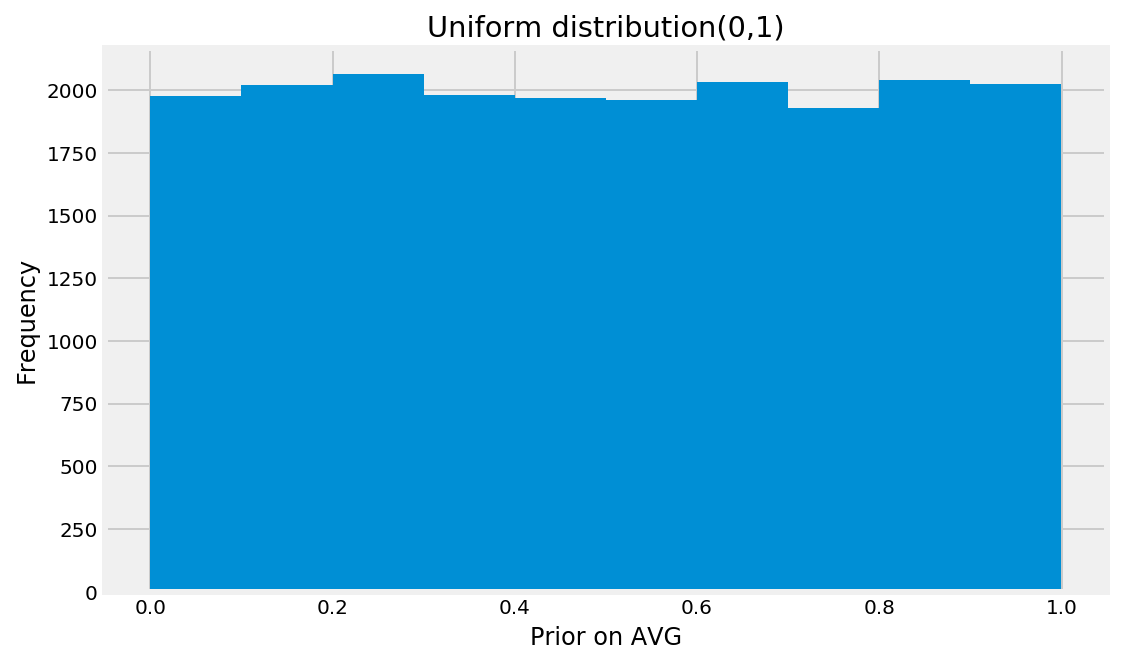

In [3]:
n_draw = 20000
prior_ni = pd.Series(np.random.uniform(0, 1, size = n_draw)) 
plt.figure(figsize=(8,5))
plt.hist(prior_ni)
plt.title('Uniform distribution(0,1)')
plt.xlabel('Prior on AVG')
plt.ylabel('Frequency')

The **prior** represents our beliefs ***before we see the data***. In the above distribution, ***any probability is almost equally likely***. Thus this means I know nothing about the player, and I don’t even have any educated guess to make about the batting average (AVG). 

Assume that 0.000 AVG is equally like as 1.000 AVG or any other probability between 0 and 1.

Let's scrape the spring training stats for [Eduardo Nunez](https://www.foxsports.com/mlb/eduardo-nunez-player-stats?seasonType=1) of the Boston Red Sox.

In [4]:
en_url_st = "https://www.foxsports.com/mlb/eduardo-nunez-player-stats?seasonType=3"
eduardo_nunez_spring = batting_stats(en_url_st)

In [5]:
eduardo_nunez_spring

,BATTING,Team,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,AVG,OBP,SLG,OPS
0,2018,BOS,11,30,27,3,7,0,0,0,4,0,1,2,2,0.259,0.333,0.259,0.592


The data we observe says there was 27 AB, and 7 H, hence a 0.260 AVG. 

This can be represented by a **binomial distribution**. A random variable $x$ that has a binomial distribution represents the number of successes in a sequence of $n$ independent hit/miss trials, each of which yields success with probability $p$. 

In case of AVG, AVG is the probability of success, AB is the number of at-bats, and H is the number of hits.

## 2. A simplistic generative model for the posterior

Ricky Kim defines a simplistic generative model: Randomly pick one probability value from the uniform distribution above, and use this value as parameter for our generative model. 

Let's say the value we randomly pick is 0.230, this means 23% chance of a hit. If the result of the generative model matches the result we observed, then we keep the probability value 0.230 Otherwise we repeat generation until we finally get a distribution of probability that matches our observation. This becomes our **posterior**.

This generative model is even simpler than our Metropolis algorithm, and we will see that it mostly ***does not work***.

27
7
Number of draws left: 688, Posterior mean: 0.272, Posterior median: 0.261, Posterior 95% quantile interval: 0.134-0.452


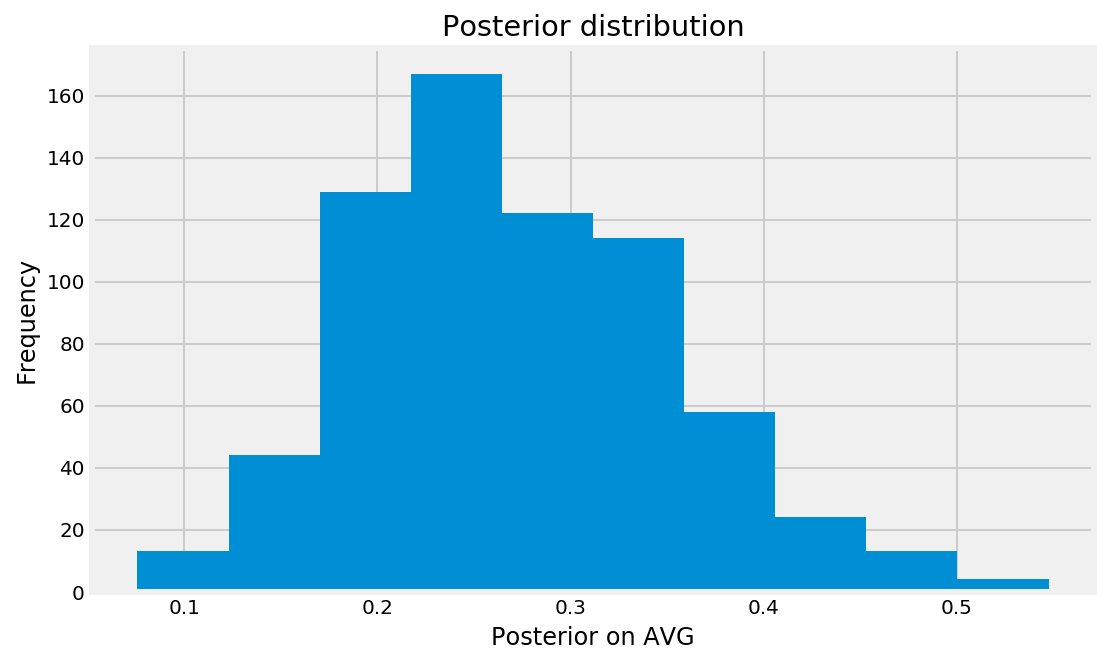

In [6]:
def posterior(n_atbat, k_hits, prior):
    hit = list()
    for p in prior:
        hit.append(np.random.binomial(n_atbat, p))
        
    posterior = prior[list(map(lambda x: x == k_hits, hit))]
    plt.figure(figsize=(8,5))
    plt.hist(posterior)
    plt.title('Posterior distribution')
    plt.xlabel('Posterior on AVG')
    plt.ylabel('Frequency')
    print('Number of draws left: %d, Posterior mean: %.3f, Posterior median: %.3f, Posterior 95%% quantile interval: %.3f-%.3f' % 
      (len(posterior), posterior.mean(), posterior.median(), posterior.quantile(.025), posterior.quantile(.975)))

en_n_atbat_st = int(eduardo_nunez_spring[['AB','H']].iloc[-1][0])
en_k_hits_st = int(eduardo_nunez_spring[['AB','H']].iloc[-1][1])
print(en_n_atbat_st)
print(en_k_hits_st)
posterior(en_n_atbat_st, en_k_hits_st, prior_ni)

So we refined our **prior** to a **posterior**. That seemed to have worked.

The 95% quantile interval in the posterior distribution is called **credible interval**, and is to be contrasted to the **confidence interval** in the frequentist sense.

One major distinction between Bayesian's credible interval and Frequentist's confidence interval is their ***interpretation***: The Bayesian probability reflects a person’s **subjective** beliefs: The true parameter is inside a credible interval with measurable probability. This is appealing because it enables you to make a direct probability statement about parameters. Many people find this concept to be a more natural way of understanding a probability interval.

A **confidence interval**, on the other hand, enables you to make a claim that the interval covers the true parameter: If we gather a new sample, and calculate the confidence interval, and repeat this many times, 95% of those intervals we calculated will have true AVG value within the interval.

- Credible Interval: "Given our observed data, there is a 95% probability that the true value of AVG falls within the credible interval" 

- Confidence Interval: "There is a 95% probability that when I compute confidence interval from data of this sort, the true value of AVG will fall within the confidence interval."

The credible interval is a statement of probability about the parameter value given fixed bounds. The confidence interval is a probability about the bounds given a fixed parameter value.

Often, what we would like to know is about the **true parameters**, not about the **bounds** of the parameters.

## 3. Regular Seasons

Let's take batting average records from the regular season.

In [7]:
en_url_rs = "https://www.foxsports.com/mlb/eduardo-nunez-player-stats?seasonType=1"
eduardo_nunez_regular = batting_stats(en_url_rs)

In [8]:
eduardo_nunez_regular

,BATTING,Team,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,AVG,OBP,SLG,OPS
0,2018,BOS,127,502,480,56,127,23,3,10,44,7,2,16,69,0.265,0.289,0.388,0.677
1,2019,BOS,60,174,167,13,38,7,0,2,20,5,1,4,27,0.228,0.243,0.305,0.548


#### For 2018:

480
127
Number of draws left: 22, Posterior mean: 0.263, Posterior median: 0.261, Posterior 95% quantile interval: 0.238-0.292


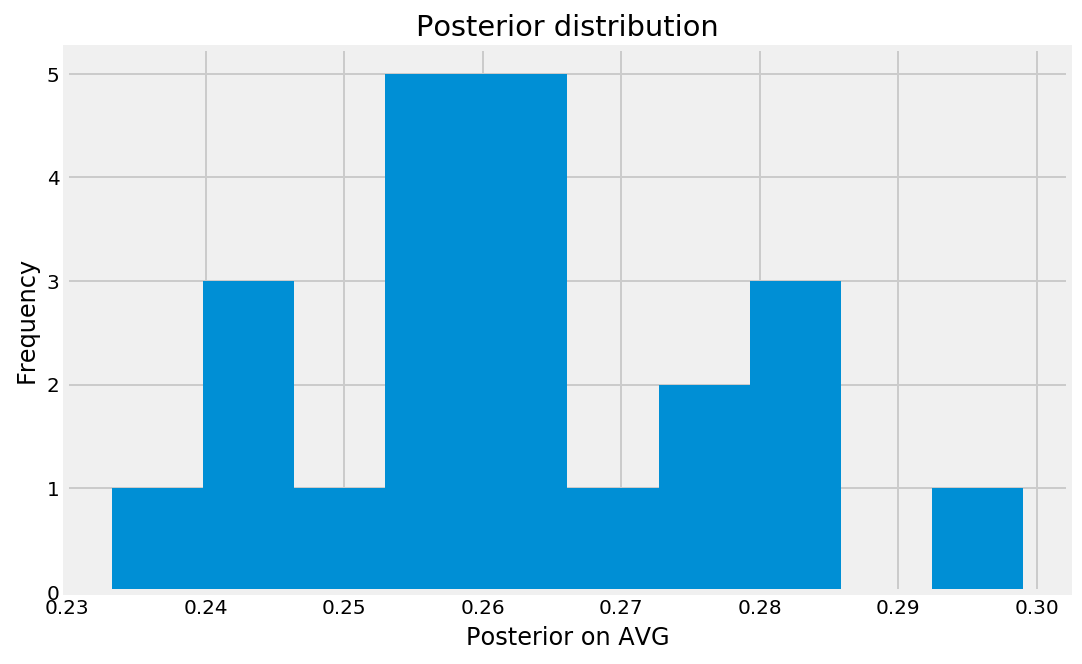

In [9]:
en_n_atbat_2018 = int(eduardo_nunez_regular[['AB','H']].iloc[-2][0])
en_k_hits_2018 = int(eduardo_nunez_regular[['AB','H']].iloc[-2][1])
print(en_n_atbat_2018)
print(en_k_hits_2018)
posterior(en_n_atbat_2018, en_k_hits_2018, prior_ni)

#### For 2019:

167
38
Number of draws left: 141, Posterior mean: 0.229, Posterior median: 0.226, Posterior 95% quantile interval: 0.168-0.290


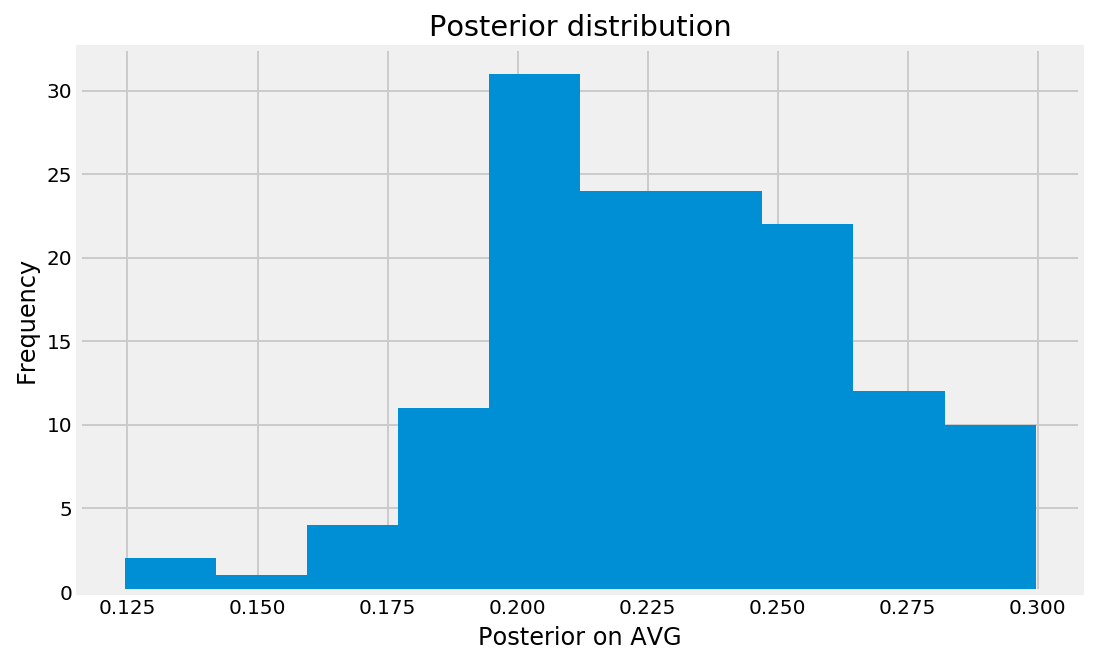

In [10]:
en_n_atbat_2019 = int(eduardo_nunez_regular[['AB','H']].iloc[-1][0])
en_k_hits_2019 = int(eduardo_nunez_regular[['AB','H']].iloc[-1][1])
print(en_n_atbat_2019)
print(en_k_hits_2019)
posterior(en_n_atbat_2019, en_k_hits_2019, prior_ni)

## 4. From regular season 2018 prior to regular season 2019 posterior

These are the regular season stats from 2018.

In [11]:
eduardo_nunez_regular.iloc[-2]

BATTING     2018
Team         BOS
G            127
PA           502
AB           480
R             56
H            127
2B            23
3B             3
HR            10
RBI           44
SB             7
CS             2
BB            16
SO            69
AVG        0.265
OBP        0.289
SLG        0.388
OPS        0.677
Name: 0, dtype: object

and for 2019:

In [12]:
eduardo_nunez_regular.iloc[-1]

BATTING     2019
Team         BOS
G             60
PA           174
AB           167
R             13
H             38
2B             7
3B             0
HR             2
RBI           20
SB             5
CS             1
BB             4
SO            27
AVG        0.228
OBP        0.243
SLG        0.305
OPS        0.548
Name: 1, dtype: object

If we take 2018 regular season stats for our prior, it is not a uniform distribution anymore.

The [Beta distribution](https://www.statlect.com/probability-distributions/beta-distribution) is a continuous probability distribution with two parameters, $\alpha$ and $\beta$. One of its most common uses is to model one’s uncertainty about the probability of success of an experiment. 

In particular, the conditional distribution of $x$, conditional on having observed $k$ successes out of $n$ trials, is a Beta distribution with parameters $k+1$ as $\alpha$ and $n−k+1$ as $\beta$.

I did not use the $+1$ in the Celtics' notebook in order to simplify, but ***I should have***!

In [13]:
eduardo_nunez_regular.iloc[-2].AB

480

In [14]:
eduardo_nunez_regular.iloc[-2].H

127

This is the beta distribution for Eduardo Nunez, given prior information from season 2018.

Text(0, 0.5, 'Frequency')

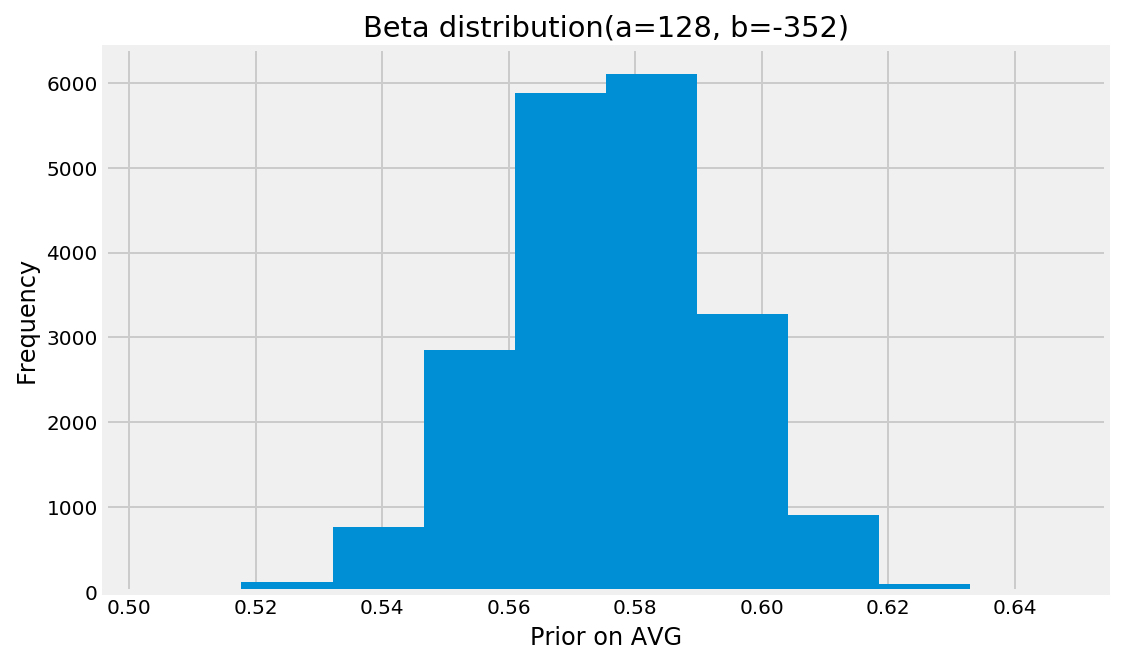

In [18]:
n_draw = 20000
prior_atbat = int(eduardo_nunez_regular.iloc[-2].AB)
prior_hits = int(eduardo_nunez_regular.iloc[-2].H)
prior_i = pd.Series(np.random.beta(prior_atbat + 1, prior_atbat - prior_hits + 1, size = n_draw)) 
plt.figure(figsize=(8,5)) 
plt.hist(prior_i)
plt.title('Beta distribution(a=%d, b=%d)' % (prior_hits + 1,prior_hits - prior_atbat + 1))
plt.xlabel('Prior on AVG')
plt.ylabel('Frequency')

Can we try to use this information to get the posterior for season 2019 using our simplistic `posterior()` function previously defined?

Number of draws left: 0, Posterior mean: nan, Posterior median: nan, Posterior 95% quantile interval: nan-nan


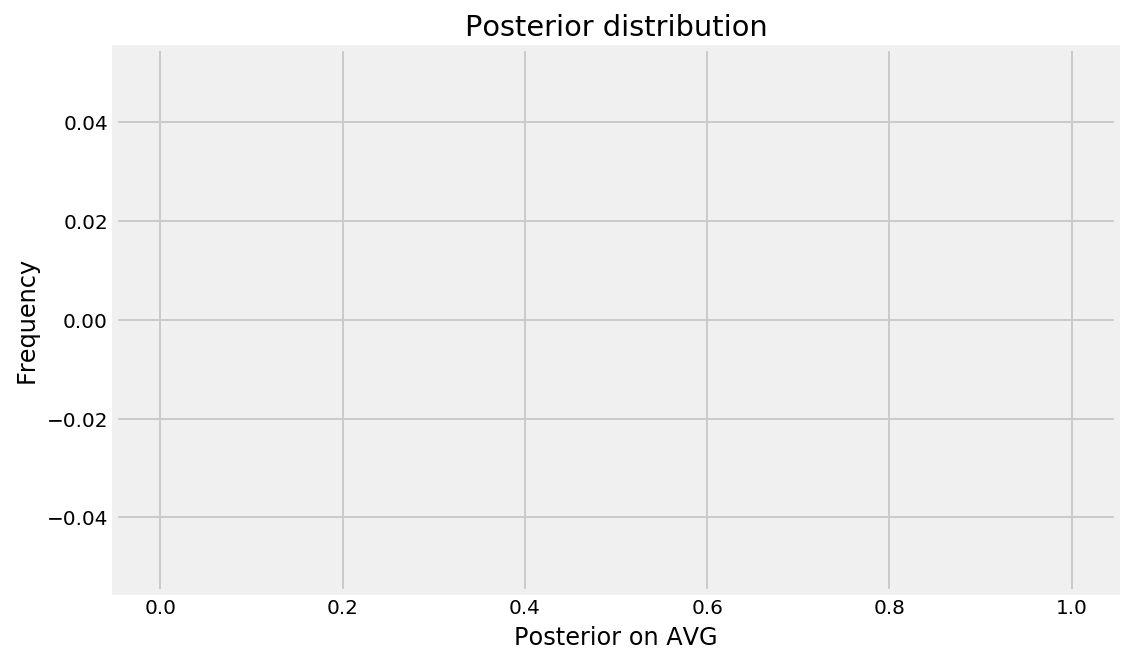

In [19]:
posterior(en_n_atbat_2019, en_k_hits_2019, prior_i)

Oops... It doesn't work. That function is much too simplistic. We need a more powerful function, like `NUTS` from `pymc3`.

Let's generate observations according to hits and at-bats for 2019:

In [20]:
def observed_data_generator(n_try, observed_data):
    result = np.ones(observed_data)
    fails = n_try - observed_data
    result = np.append(result, np.zeros(fails))
    return result

In [21]:
en_observed = observed_data_generator(en_n_atbat_2019, en_k_hits_2019)

Let's plug those into a pymc3 model and generate the posterior.

In [22]:
import pymc3 as pm
with pm.Model() as model_1:    
    E_p = pm.Beta('EN_AVG', prior_hits + 1, prior_atbat - prior_hits + 1)
    EN = pm.Bernoulli('EN', p=E_p, observed = en_observed)  
    start = pm.find_MAP()
    trace = pm.sample(10000, start=start)

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
D:\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
D:\Anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to init

D:\Anaconda3\lib\site-packages\pymc3\plots\__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002016402FFD0>],
      dtype=object)

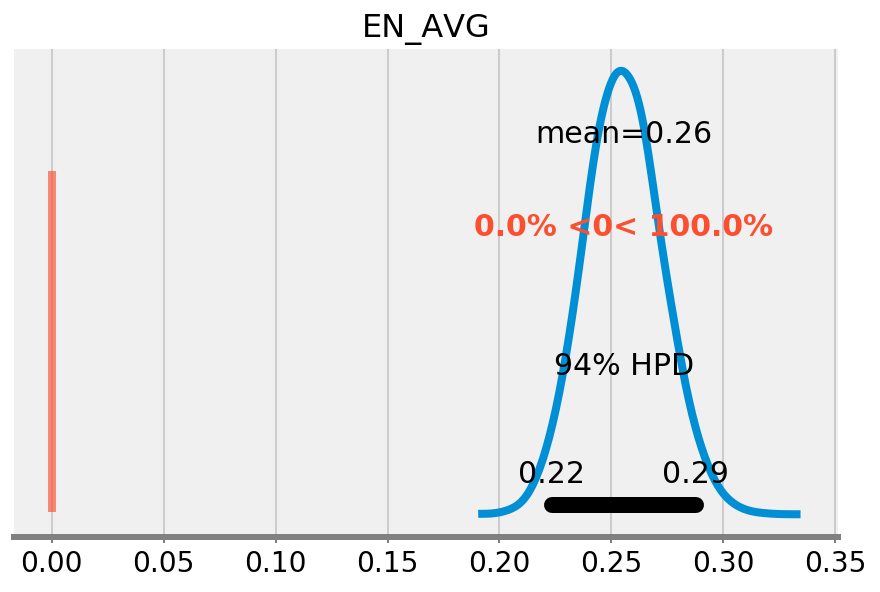

In [23]:
pm.plot_posterior(trace, varnames=['EN_AVG'],ref_val=0)

The 95% quantile region has been narrowed compared to our posterior with the uniform prior.  

We are 95% certain that the true AVG of Eduardo Nunez will lie between 0.22 to 0.29. We need more data to narrow our region of credibility.

## 5. Increasing observations

For this scenario, let's conjoin stats from regular seasons 2018 and 2019. 

In [24]:
en_url = "https://www.foxsports.com/mlb/eduardo-nunez-player-stats?seasonType=1"
eduardo_nunez_reg = batting_stats(en_url)
eduardo_nunez_reg

,BATTING,Team,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,AVG,OBP,SLG,OPS
0,2018,BOS,127,502,480,56,127,23,3,10,44,7,2,16,69,0.265,0.289,0.388,0.677
1,2019,BOS,60,174,167,13,38,7,0,2,20,5,1,4,27,0.228,0.243,0.305,0.548


In [25]:
en_prior_atbat_18_19 = pd.to_numeric(eduardo_nunez_reg.AB).sum()
en_prior_atbat_18_19

647

In [26]:
en_prior_hits_18_19 = pd.to_numeric(eduardo_nunez_reg.H).sum()
en_prior_hits_18_19

165

In [27]:
en_observed_18_19 = observed_data_generator(en_prior_atbat_18_19, en_prior_hits_18_19)

In [28]:
import pymc3 as pm
with pm.Model() as model_2:    
    E1819_p = pm.Beta('EN_AVG1819', en_prior_hits_18_19 + 1, en_prior_atbat_18_19 - en_prior_hits_18_19 + 1)
    EN1819 = pm.Bernoulli('EN1819', p=E1819_p, observed = en_observed_18_19)  
    start = pm.find_MAP()
    trace1819 = pm.sample(10000, start=start)

logp = -364.21, ||grad|| = 0.97689: 100%|██████████| 5/5 [00:00<00:00, 387.54it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EN_AVG1819]
Sampling 4 chains: 100%|██████████| 42000/42000 [03:15<00:00, 107.11draws/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000201632EDFD0>],
      dtype=object)

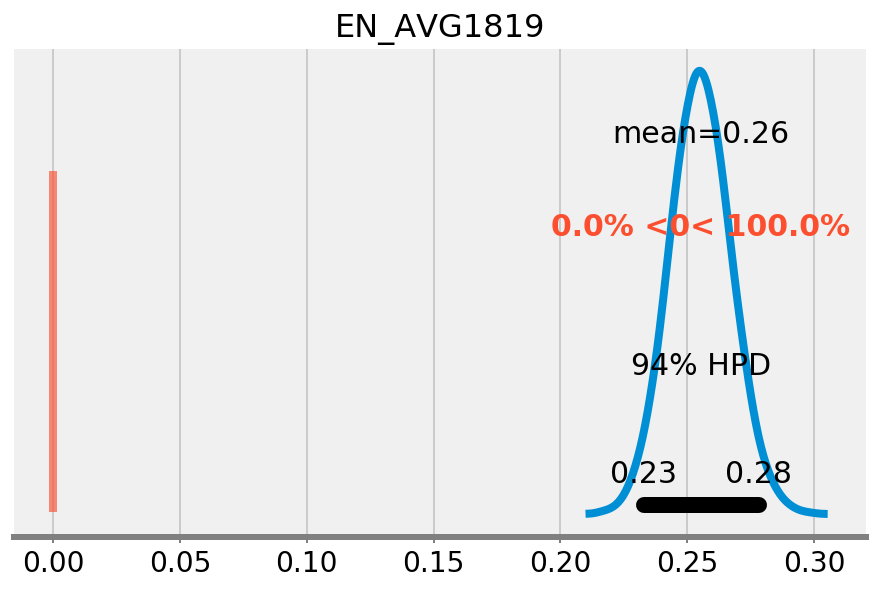

In [29]:
pm.plot_posterior(trace1819, varnames=['EN_AVG1819'],ref_val=0)

Now I can say that I am 95% certain that the true batting average of Eduardo Nunez will lie between 0.23 to 0.28. The credible interval is narrower than before!

## 6. Comparing two players

I want to compare two players from the Boston Red Sox and see who's better in terms of batting average. The data I observe is results from regular season 2019, and the prior knowledge I have is from spring season and regular season 2018. 

I want to compare [Eduardo Nunez](https://www.foxsports.com/mlb/eduardo-nunez-player-stats?seasonType=1) to [Xander Bogaerts](https://www.foxsports.com/mlb/xander-bogaerts-player-stats).

We leverage pymc3.

In [30]:
xb_url_st = "https://www.foxsports.com/mlb/xander-bogaerts-player-stats?seasonType=3"
xb_url_reg = "https://www.foxsports.com/mlb/xander-bogaerts-player-stats?seasonType=1"
xander_bogaerts_spring = batting_stats(xb_url_st)
xander_bogaerts_reg = batting_stats(xb_url_reg)

In [31]:
xander_bogaerts_spring

,BATTING,Team,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,AVG,OBP,SLG,OPS
0,2018,BOS,18,52,47,9,15,4,0,3,8,0,0,4,10,0.319,0.365,0.596,0.961


In [32]:
xb_n_atbat = int(xander_bogaerts_spring.iloc[0].AB)
xb_k_hits = int(xander_bogaerts_spring.iloc[0].H)

In [33]:
xb_prior = pd.DataFrame(xander_bogaerts_reg.iloc[1]).transpose().append(xander_bogaerts_spring.iloc[0])
xb_prior

,BATTING,Team,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,AVG,OBP,SLG,OPS
1,2019,BOS,155,698,614,110,190,52,0,33,117,4,2,76,122,0.309,0.384,0.555,0.939
0,2018,BOS,18,52,47,9,15,4,0,3,8,0,0,4,10,0.319,0.365,0.596,0.961


In [34]:
xb_prior_atbat = pd.to_numeric(xb_prior.AB).sum()
xb_prior_hits = pd.to_numeric(xb_prior.H).sum()

In [35]:
en_observed = observed_data_generator(en_n_atbat, en_k_hits)
xb_observed = observed_data_generator(xb_n_atbat, xb_k_hits)

NameError: name 'en_n_atbat' is not defined

In [ ]:
import pymc3 as pm
with pm.Model() as model_a:    
    E_p = pm.Beta('EN_AVG', en_prior_hits + 1, en_prior_atbat - en_prior_hits + 1)
    X_p = pm.Beta('XB_AVG', xb_prior_hits + 1, xb_prior_atbat - xb_prior_hits + 1)
    EN = pm.Bernoulli('EN', p=E_p, observed = en_observed) 
    XB = pm.Bernoulli('XB', p=X_p, observed = xb_observed) 
    EvX = pm.Deterministic('EvX', E_p - X_p)
    start = pm.find_MAP()
    trace = pm.sample(10000, start=start)

In [ ]:
pm.plot_posterior(trace, varnames=['EN_AVG','XB_AVG','EvX'],ref_val=0)

In [ ]:
pm.summary(trace)

### Conclusion

I can see that Xander Bogaerts has a better batting average.